In [28]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite, community
import math
from collections import Counter
import numpy as np

DATA_DIR = '../../data/'
YEAR = 2023

stock_tx =  pd.read_csv(f'{DATA_DIR}cleaned/2021-2023/stocks.csv')
stock_tx = stock_tx[stock_tx['year'] == YEAR]

stock_tx.head()


,transaction_date,ticker,asset_description,type,amount,state,ptr_link,industry,sector,party,chamber,member,year,last_name,member_id
67,2023-03-20,SPY,SPDR S7P 500,purchase,8000,TX,https://disclosures-clerk.house.gov/public_dis...,NaN,NaN,R,House,Dan Crenshaw,2023,crenshaw,C001120
68,2023-03-06,ABBV,AbbVie Inc,purchase,8000,NJ,https://disclosures-clerk.house.gov/public_dis...,Major Pharmaceuticals,Health Care,D,House,Josh Gottheimer,2023,gottheimer,G000583
69,2023-03-24,ABBV,AbbVie Inc,sale_partial,8000,NJ,https://disclosures-clerk.house.gov/public_dis...,Major Pharmaceuticals,Health Care,D,House,Josh Gottheimer,2023,gottheimer,G000583
70,2023-03-06,ALGN,Align Technology Inc,purchase,8000,NJ,https://disclosures-clerk.house.gov/public_dis...,Industrial Specialties,Health Care,D,House,Josh Gottheimer,2023,gottheimer,G000583
71,2023-03-06,GOOG,Alphabet Inc - Class C Capital Stock,sale_partial,8000,NJ,https://disclosures-clerk.house.gov/public_dis...,"Computer Software: Programming, Data Processing",Technology,D,House,Josh Gottheimer,2023,gottheimer,G000583


In [29]:
B = nx.Graph()
for _, r in stock_tx.iterrows():
    m, t = r['member_id'], r['ticker']
    B.add_node(m, bipartite='members', party=r['party'], label=r['member'])
    B.add_node(t, bipartite='tickers', industry=r['industry'])
    B.add_edge(m, t, amount=r['amount'])

members = {n for n,d in B.nodes(data=True) if d['bipartite']=='members'}
G = bipartite.weighted_projected_graph(B, members)

print(f"Projected graph: {G.number_of_nodes()} members, {G.number_of_edges()} edges")


Projected graph: 59 members, 113 edges


In [30]:
min_shared = 2
G_thr = nx.Graph(((u,v,d) for u,v,d in G.edges(data=True) if d['weight']>=min_shared))

comms = list(community.greedy_modularity_communities(G_thr, weight='weight'))
print("Communities:", [len(c) for c in comms])

node2comm = {n:i for i,c in enumerate(comms) for n in c}


Communities: [8, 5, 5]


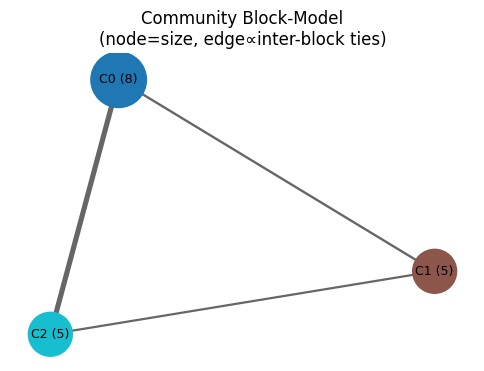

In [31]:
superG = nx.Graph()
for i,c in enumerate(comms):
    superG.add_node(i, size=len(c))
for u,v,d in G_thr.edges(data=True):
    cu,cv = node2comm[u], node2comm[v]
    if cu==cv: continue
    superG.add_edge(cu,cv, weight=superG.get_edge_data(cu,cv,{'weight':0})['weight']+d['weight'])

plt.figure(figsize=(6,4))
pos = nx.spring_layout(superG, weight='weight', seed=42)
sizes = [superG.nodes[i]['size']*200 for i in superG.nodes()]
nx.draw_networkx_nodes(superG,pos,node_size=sizes,node_color=list(superG.nodes()),cmap="tab10")
nx.draw_networkx_edges(superG,pos,width=[d['weight']/10 for _,_,d in superG.edges(data=True)],alpha=0.6)
nx.draw_networkx_labels(superG,pos,{i:f"C{i} ({superG.nodes[i]['size']})" for i in superG.nodes()},font_size=9)
plt.title("Community Block-Model\n(node=size, edge∝inter-block ties)")
plt.axis('off')
plt.show()


In [32]:
id2name  = {n:d['label'] for n,d in B.nodes(data=True) if d['bipartite']=='members'}
id2state = stock_tx[['member_id','state']].drop_duplicates().set_index('member_id')['state'].to_dict()
id2chamber = stock_tx[['member_id','chamber']].drop_duplicates().set_index('member_id')['chamber'].to_dict()
id2party = stock_tx[['member_id','party']].drop_duplicates().set_index('member_id')['party'].to_dict()

rows=[]
for i,c in enumerate(comms):
    for mid in sorted(c):
        rows.append({
            'Community': f"C{i}",
            'Name':       id2name[mid],
            'State':      id2state.get(mid,"—"),
            "Chamber":    id2chamber.get(mid),
            "Party":      id2party.get(mid)
        })
df_comms = pd.DataFrame(rows)
df_comms


,Community,Name,State,Chamber,Party
0,C0,Michael C. Burgess,TX,House,R
1,C0,Virginia Foxx,NC,House,R
2,C0,"Charles J. ""Chuck"" Fleischmann",TN,House,R
3,C0,Josh Gottheimer,NJ,House,D
4,C0,Thomas R. Carper,DE,Senate,D
5,C0,Tommy Tuberville,AL,Senate,R
6,C0,Shri Thanedar,MI,House,D
7,C0,Robert J. Wittman,VA,House,R
8,C1,Earl Blumenauer,OR,House,D
9,C1,John Curtis,UT,House,R


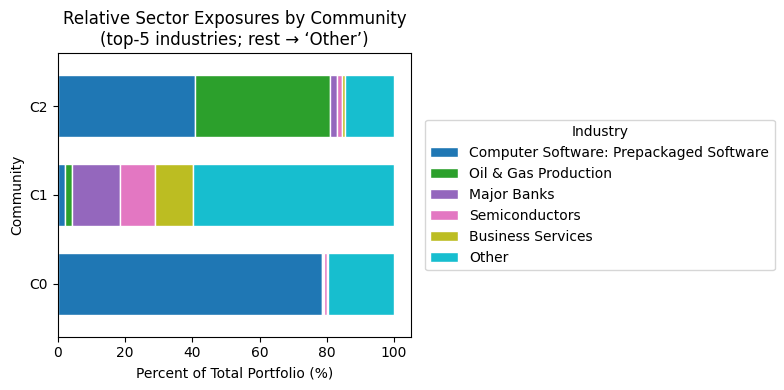

In [ ]:
in_comm = set().union(*comms)
tx = stock_tx[stock_tx['member_id'].isin(in_comm)].copy()
tx['Community'] = (
    tx['member_id']
      .map(node2comm)
      .astype(int)
      .map(lambda i: f"C{i}")
)

# — 6.2 Compute total $ by Community × Industry
sector_sum = (
    tx
    .groupby(['Community','industry'])['amount']
    .sum()
    .unstack(fill_value=0)
)

# — 6.3 Convert to fractions (relative exposures)
sector_frac = sector_sum.div(sector_sum.sum(axis=1), axis=0)

# — 6.4 Pick the global top-5 industries by total fraction
top5 = sector_frac.sum(axis=0).nlargest(10).index.tolist()

# — 6.5 Build a DataFrame with those + “Other”
sector_top5_frac = sector_frac[top5].copy()
sector_top5_frac['Other'] = sector_frac.drop(columns=top5).sum(axis=1)
sector_top5_frac = sector_top5_frac[top5 + ['Other']]

# — 6.6 (Optional) convert to percentages
sector_top5_pct = sector_top5_frac * 100

# — 6.7 Plot horizontal stacked bar
ax = sector_top5_pct.plot(
    kind='barh',
    stacked=True,
    figsize=(8, 4),
    colormap='tab10',
    edgecolor='white',
    width=0.7
)
ax.set_xlabel("Percent of Total Portfolio (%)")
ax.set_title("Relative Sector Exposures by Community\n(top-5 industries; rest → ‘Other’)")
ax.legend(
    title="Industry",
    bbox_to_anchor=(1.02, 0.5),
    loc='center left'
)
plt.tight_layout()
plt.show()

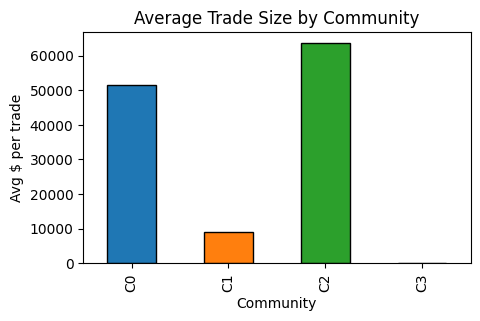

In [34]:
# %% 7.1 Compute stats
size_stats = tx.groupby('Community')['amount'].agg(['mean','median']).reindex(['C0','C1','C2','C3'])
size_stats

# %% 7.2 Plot
plt.figure(figsize=(5,3))
size_stats['mean'].plot(kind='bar', color=['C0','C1','C2','C3'], edgecolor='black')
plt.ylabel("Avg $ per trade")
plt.title("Average Trade Size by Community")
plt.show()


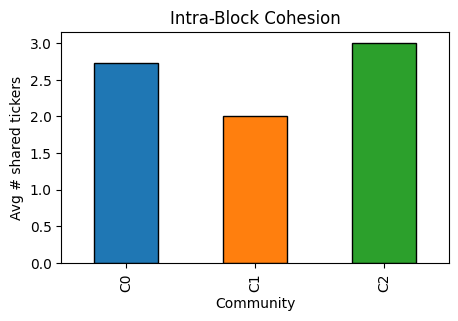

In [35]:
# %% 8.1 Build member–member weights matrix for each block
cohesion = []
for i,c in enumerate(comms):
    sub = G.subgraph(c)
    w = [d['weight'] for _,_,d in sub.edges(data=True)]
    cohesion.append({'Community':f"C{i}", 'mean_shared':np.mean(w), 'std_shared':np.std(w)})

df_cohesion = pd.DataFrame(cohesion).set_index('Community')
df_cohesion

# %% 8.2 Plot
plt.figure(figsize=(5,3))
df_cohesion['mean_shared'].plot(kind='bar', color=['C0','C1','C2','C3'], edgecolor='black')
plt.ylabel("Avg # shared tickers")
plt.title("Intra-Block Cohesion")
plt.show()


In [36]:
id2name = {
    n: data['label']
    for n, data in B.nodes(data=True)
    if data.get('bipartite') == 'members'
}

for i, comm in enumerate(comms):
    print(f"\nCommunity C{i} ({len(comm)} members):")
    for mid in sorted(comm):
        print("  -", id2name[mid], "(", B.nodes[mid]['chamber'], B.nodes[mid]['party'], ")")


Community C0 (8 members):


KeyError: 'chamber'

In [ ]:
top_tickers = set()
for comm in comms:
    tickers = []
    for m in comm:
        tickers += [nbr for nbr in B.neighbors(m) if B.nodes[nbr]['bipartite']=='tickers']
    top_tickers.update(t for t,_ in Counter(tickers).most_common(5))
members = set().union(*comms)

# 2) Aggregate total amount per (member, ticker)
agg = (
    stock_transactions
      .groupby(['member_id','ticker'], as_index=False)['amount']
      .sum()
)
sub = agg[agg.member_id.isin(members) & agg.ticker.isin(top_tickers)]

# 3) Build a fresh bipartite graph H
H = nx.Graph()
# add member nodes
for m in members:
    H.add_node(m,
               bipartite='members',
               party=B.nodes[m]['party'],
               label=B.nodes[m]['label'])
# add ticker nodes
for t in top_tickers:
    H.add_node(t, bipartite='tickers')
# add weighted edges
for _, row in sub.iterrows():
    H.add_edge(row['member_id'], row['ticker'], weight=row['amount'])

# 4) Compute layout
pos = bipartite_layout(H, members)

# 5) Node colors: party → red/blue, tickers → light green
node_colors = []
for n in H.nodes():
    p = H.nodes[n].get('party')
    if p == 'Republican':
        node_colors.append('red')
    elif p == 'Democrat':
        node_colors.append('blue')
    else:
        node_colors.append('lightgreen')

# 6) Edge widths: scale so max width is ~5
weights = [d['weight'] for _,_,d in H.edges(data=True)]
max_w   = max(weights) if weights else 1
edge_widths = [
    max(0.5, math.sqrt(w / max_w) * 5)  # √(w/max)→[0,1], ×5, floor at 0.5
    for w in weights
]

# 7) Draw
plt.figure(figsize=(12, 6))
nx.draw_networkx_nodes(H, pos,
                       node_size=50,
                       node_color=node_colors,
                       alpha=0.9)
nx.draw_networkx_edges(H, pos,
                       width=edge_widths,
                       alpha=0.6)
nx.draw_networkx_labels(H, pos,
                       labels={t:t for t in top_tickers},
                       font_size=10)
plt.title("Members ↔ Top Tickers\n(edge-width ∝ total $ traded, nodes colored by party)")
plt.axis('off')
plt.show()